In [92]:
import os
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import astropy.units as u

from config.plotting import save_figure, set_plotting_defaults, Tab10
from config.units import Gauss, flux_unit
from spectrum_fit_electrons import SynchrotronSpectrumFit
from config.settings import MCMC_ELECTRONS_SYNCH_ONLY, SPECTRUM_DIR
from src.synchrotron_emission import electron_synchrotron_emission_power, electron_synchrotron_emission_luminosity

set_plotting_defaults()

In [93]:
nsteps, nwalkers = 2000, 64

data = pickle.load(open(os.path.join(MCMC_ELECTRONS_SYNCH_ONLY, f"electrons_{nsteps}n_{nwalkers}w_no_cutoff.pck"), "rb"))

result, synch = data[0], data[1]

In [94]:
data = pickle.load(open(os.path.join(SPECTRUM_DIR, "UHE_spectrum_corrected.pck"), "rb"))

names, e, f_cor, f_l_cor, f_p_cor, e_l, e_p = data

In [95]:
result_mod = result[result[:, 1] > 2.2]
result_mod2 = result_mod[abs(result_mod[:, 4] - 3.0) < 2.5]

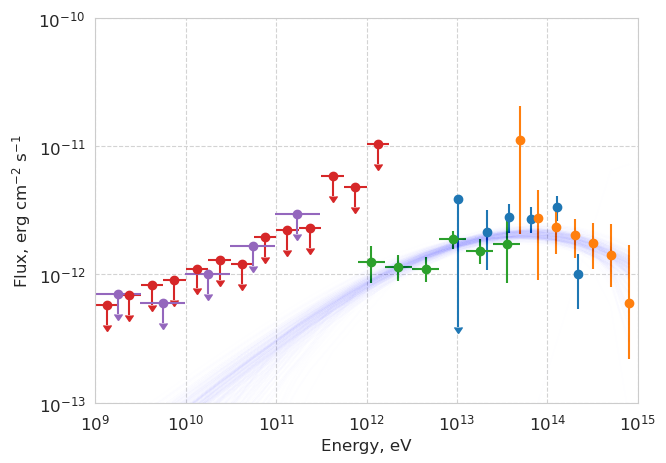

In [96]:
for i, name in enumerate(names):
    plt.errorbar(e[i], f_cor[i], xerr=[e_l[i], e_p[i]], yerr=[f_l_cor[i], f_p_cor[i]],
                 fmt='o', linestyle='None', uplims=f_p_cor[i] <= 0,
                 color=Tab10[i], label=f' ')

for res in result_mod2[::10]:
    plt.plot(synch.photon_energy, synch.model(res), alpha=.005, color='blue')

plt.xscale('log')
plt.xlim(1e9, 1e15)
plt.xlabel("Energy, eV")

plt.yscale('log')
plt.ylim(1e-13, 1e-10)
plt.ylabel(r"Flux, $\mathrm{erg~cm^{-2}~s^{-1}}$")
plt.show()

In [97]:
print(np.mean(result_mod2, axis=0))
print(result_mod2[np.argmax(result_mod2[:, 4])])
print(np.max(result_mod2, axis=0))
print(np.min(result_mod2, axis=0))

[ 1.41573252  2.85636659 -1.19161558  9.99999823  2.52721944]
[ 0.64191755  2.64493039  0.34218163 10.00002626  4.26468533]
[ 3.1941956   3.01876341  2.99423836 10.00009949  4.26468533]
[ 0.4164214   2.31764786 -2.99242343  9.99990019  0.50292969]


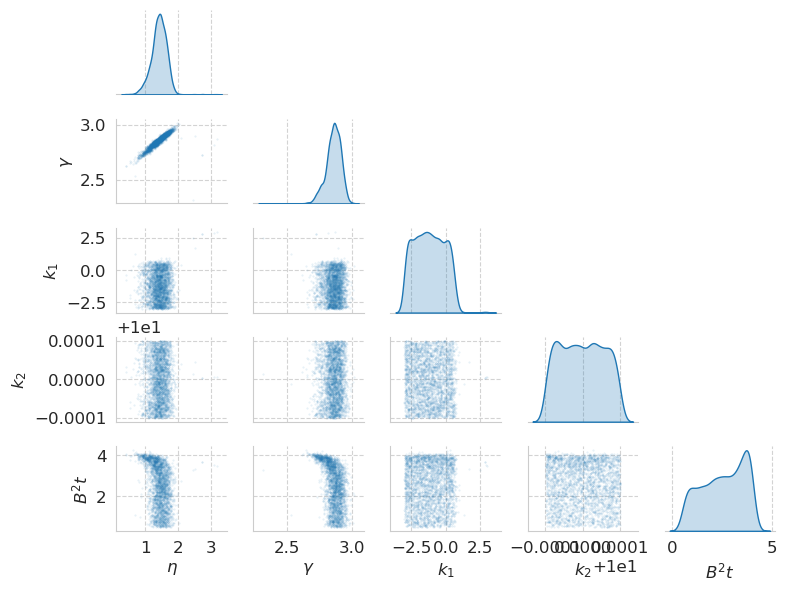

In [98]:
columns = [r"$\eta$", r"$\gamma$", r"$k_1$", r"$k_2$", r"$B^2t$"]
fs = pd.DataFrame(result_mod2, columns=columns)

g = sns.pairplot(fs, diag_kind="kde",
                plot_kws=dict(marker=".", linewidth=0, alpha=.1, s=10),
                corner=True, height=1.2, aspect=4/3)
# g.map_lower(sns.kdeplot, levels=5, color=".2", alpha=.3)
# save_figure(f"pairplot{nsteps}")
plt.show()

In [105]:
# calculate the synchrotron_emission
bfield1 = 1e-6 * Gauss
bfield5 = 5e-6 * Gauss
synch_photon_energy = np.logspace(-8, 15, 100) * u.eV

result_chosen = result_mod2[::50]
synch_flux1 = np.zeros([result_chosen.shape[0], synch_photon_energy.size]) * flux_unit
synch_flux5 = np.zeros([result_chosen.shape[0], synch_photon_energy.size]) * flux_unit
e_volume = synch.volume_approximation(synch.electron_energy)

for i, res_i in enumerate(result_chosen):
    if res_i[4] < 1 or res_i[2] < 0:
        continue
    print(i, end=' ')
    e_density = synch.cooled_spectrum(res_i)
    synch_rad1 = electron_synchrotron_emission_luminosity(synch.electron_energy, e_density, e_volume,
                                                          synch_photon_energy, bfield1)
    synch_rad5 = electron_synchrotron_emission_luminosity(synch.electron_energy, e_density, e_volume,
                                                          synch_photon_energy, bfield5)
    synch_flux1[i] = synch_rad1 * synch_photon_energy / synch.area
    synch_flux5[i] = synch_rad5 * synch_photon_energy / synch.area

4 5 8 10 11 20 34 43 48 53 54 

In [106]:
from spectrum.measurements_xray import x_ray_measurements
from spectrum.measurements_radio import radio_measurements
from spectrum.measurements_optical import optical_measurements

Swift/XRT + NuStar, 2014 (hard)
NuStar, 2021
XRISM, 2024 (broad)
[2574.09259091] eV [5808.00938138] eV [2.06637316e-12] erg / (s cm2) [1.25361223e-12] erg / (s cm2)


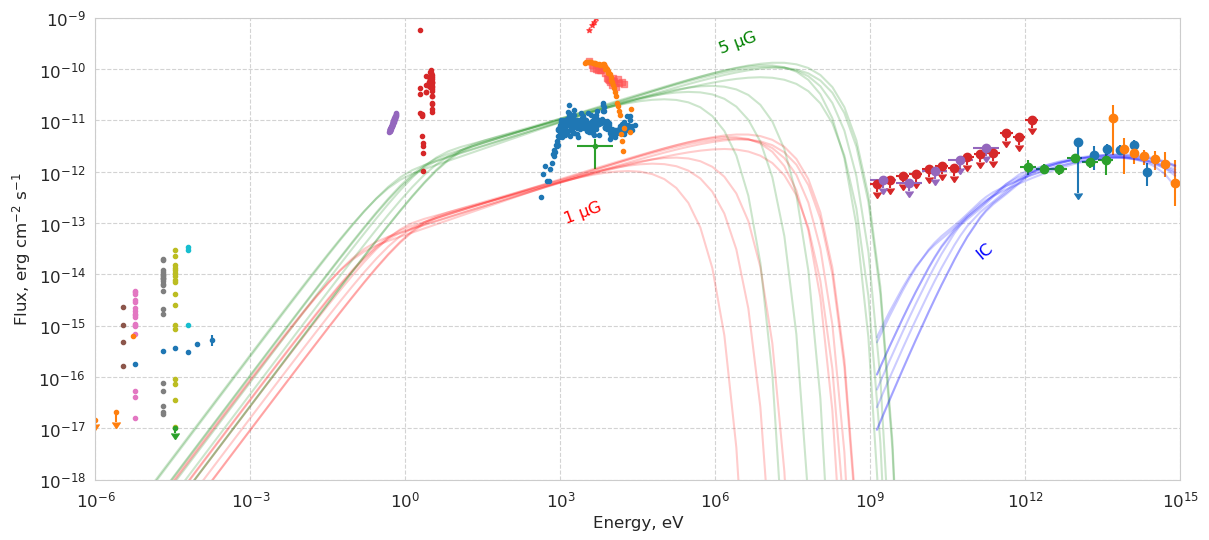

In [128]:
plt.figure(figsize=(14, 6))
for i, name in enumerate(names):
    plt.errorbar(e[i], f_cor[i], xerr=[e_l[i], e_p[i]], yerr=[f_l_cor[i], f_p_cor[i]],
                 fmt='o', linestyle='None', uplims=f_p_cor[i] <= 0,
                 color=Tab10[i], label=f' ')

x_ray_measurements()
optical_measurements()
radio_measurements()

for i, res in enumerate(result_chosen):
    if res[4] < 2.3 or res[2] < 0:
        continue
    # plot gamma-ray spectrum
    plt.plot(synch.photon_energy, synch.model(res), alpha=.2, color='blue')
    # plot synchrotron spectrum
    plt.plot(synch_photon_energy, synch_flux1[i], alpha=.2, color='red')
    plt.plot(synch_photon_energy, synch_flux5[i], alpha=.2, color='green')

plt.text(1e3, 1e-13, r'$1~\mathrm{\mu G}$', color='red', rotation=20)
plt.text(1e6, 2e-10, r'$5~\mathrm{\mu G}$', color='green', rotation=20)
plt.text(1e11, 2e-14, 'IC', color='blue', rotation=40)

plt.xscale('log')
plt.xlim(1e-6, 1e15)
plt.xlabel("Energy, eV")

plt.yscale('log')
plt.ylim(1e-18, 1e-9)
plt.ylabel(r"Flux, $\mathrm{erg~cm^{-2}~s^{-1}}$")
plt.show()